In [1]:
## Additional files ravi
import sys
functions_at = '/proj/src'
sys.path.append(functions_at)
from Py.libs import *
from Py.func import *

p_data = pd.read_feather("/proj/ext_dir/data_ravi/01_11_2024/pheno_file.feather")
g_data = pd.read_feather("/proj/ext_dir/data_ravi/01_11_2024/geno_file.feather")
g_data = g_data.set_index('genotype')

cv_data = read_json("/proj/ext_dir/data_ravi/01_11_2024/validation_sets.json")
pred_ref =  pd.read_feather("/proj/ext_dir/data_ravi/11_11_2024/egblup_prediction_abilities.feather")
pred_ref['Run'] = None

In [2]:
# Define a cv file
all_keys = cv_data.keys()
key_idx = [f'run_{x}' for x in range(len(all_keys))]

# Mapping old keys to new keys using a dictionary
key_mapping = dict(zip(all_keys, key_idx))

# Renaming the keys in cv_data using the mapping
cv_data_mod = {key_mapping[old_key]: value for old_key, value in cv_data.items()}

# Go through each list and subtract 1 from each number
for run in cv_data_mod.values():
    for key in run:
        run[key] = [x - 1 for x in run[key]]

# write the file
for idx in pred_ref.train_set:
    pred_ref.loc[pred_ref.train_set == idx, 'Run'] = key_mapping[idx.replace(' + ', '_')]

write_json(cv_data_mod, "/proj/inputs/ravi_acr_cv.json") # saves the paths
write_json(key_mapping, "/proj/inputs/ravi_key_mappings.json") # saves the paths
pred_ref.to_csv("/proj/inputs/ravi_train_sizes.csv", index=False)

In [3]:
# Data preprocessing
## Scale data
g_data_mod, acr_g_scl = scale_data(g_data, g_data.columns, g_data.index)
p_data_mod, acr_p_scl = scale_data(p_data.loc[:, "blups"].values.reshape(-1, 1), 
                                   ["blups"],
                                   p_data.index)

acr_p = p_data.merge(p_data_mod, how='left', left_index=True, right_index=True, 
                         sort=False, suffixes=('_raw', '_scaled'))

# reshape geno data to fit the p_data
np_g_data = np.stack([g_data_mod[g_data_mod.index == idx].iloc[0,:].values for idx in acr_p['genotype']])
acr_g = np_g_data.reshape(np_g_data.shape[0], np_g_data.shape[1], 1)

# save data
out_paths = {}
out_paths['ravi_acr_g.npy'] = "/proj/inputs/ravi_acr_g.npy"
out_paths['ravi_acr_p.csv'] = "/proj/inputs/ravi_acr_p.csv"
out_paths['ravi_acr_g.scl'] = "/proj/inputs/ravi_acr_g.scl"
out_paths['ravi_acr_p.scl'] = "/proj/inputs/ravi_acr_p.scl"

np.save(out_paths['ravi_acr_g.npy'], acr_g)
acr_p.to_csv(out_paths['ravi_acr_p.csv'], index=False)
write_pkl(acr_g_scl, out_paths['ravi_acr_g.scl'])
write_pkl(acr_p_scl, out_paths['ravi_acr_p.scl'])

In [4]:
# Create slurm scripts and run the predictions
# Check if all pred files exist and get correlations
files = read_json("/proj/outputs/create_slurm_scripts/pred_dirs_paths.json")
files_df = pd.DataFrame(files).transpose().reset_index()
to_get = files_df['index'].str.contains("ravi", case=False, na=False)
file_paths = [f'{x}/output.csv' for x in files_df.loc[to_get, 'pred_at'].to_list()]
logs = [f'{x}/predictions.log' for x in files_df.loc[to_get, 'base_folder'].to_list()]

for path in file_paths:
    if not os.path.exists(path):
        print(f"File not found: {path}")
        
# get correlations
correlations = []
for path in file_paths:
    if os.path.exists(path):  # Check if the file exists
        # Read the output CSV file
        output = pd.read_csv(path)
        
        # Extract the run_idx (assuming it's in the DataFrame)
        run_idx = output['run_idx'].iloc[0]  # Assuming 'run_idx' is consistent in the file
        
        # Calculate the correlation between 'obs' and 'pred' and round it to two decimal places
        correlation_value = output['obs'].corr(output['pred']).round(2)
        
        # Append the correlation value along with the run_idx to the list
        correlations.append({'Run': run_idx, 'Pred_CNN': correlation_value, 'File Path': path})
    else:
        print(f"File not found: {path}")

# Create a DataFrame with the correlation values
correlation_df = pd.DataFrame(correlations)
combined_df = pd.merge(pred_ref, correlation_df, left_on='Run', right_on='Run', how='left')

output_file = "/proj/outputs/correlation_values.csv"  # Specify the path where you want to save the file
combined_df.to_csv(output_file, index=False)

# Check the range (min and max) of the correlations
min_corr = combined_df['Pred_CNN'].min()
max_corr = combined_df['Pred_CNN'].max()

# Print the range
print(f"Minimum correlation: {min_corr}")
print(f"Maximum correlation: {max_corr}")

# Remove rows with missing values
df_cleaned = combined_df.dropna(subset=['Pred_CNN']).reset_index(drop = True) #results from two files removed

# Print trends
r_cnn = df_cleaned['train_size'].corr(df_cleaned['Pred_CNN']).round(2)
r_gblup = df_cleaned['train_size'].corr(df_cleaned['prediction_ablity']).round(2)
print(f'correlation:\nCNN = {r_cnn}\nE-GBLUP = {r_gblup}')

File not found: /proj/outputs/create_slurm_scripts/acr_CNN_ravi_acr_cv/run_37/pred/output.csv
File not found: /proj/outputs/create_slurm_scripts/acr_CNN_ravi_acr_cv/run_41/pred/output.csv
File not found: /proj/outputs/create_slurm_scripts/acr_CNN_ravi_acr_cv/run_37/pred/output.csv
File not found: /proj/outputs/create_slurm_scripts/acr_CNN_ravi_acr_cv/run_41/pred/output.csv
Minimum correlation: -0.03
Maximum correlation: 0.6
correlation:
CNN = 0.74
E-GBLUP = 0.62


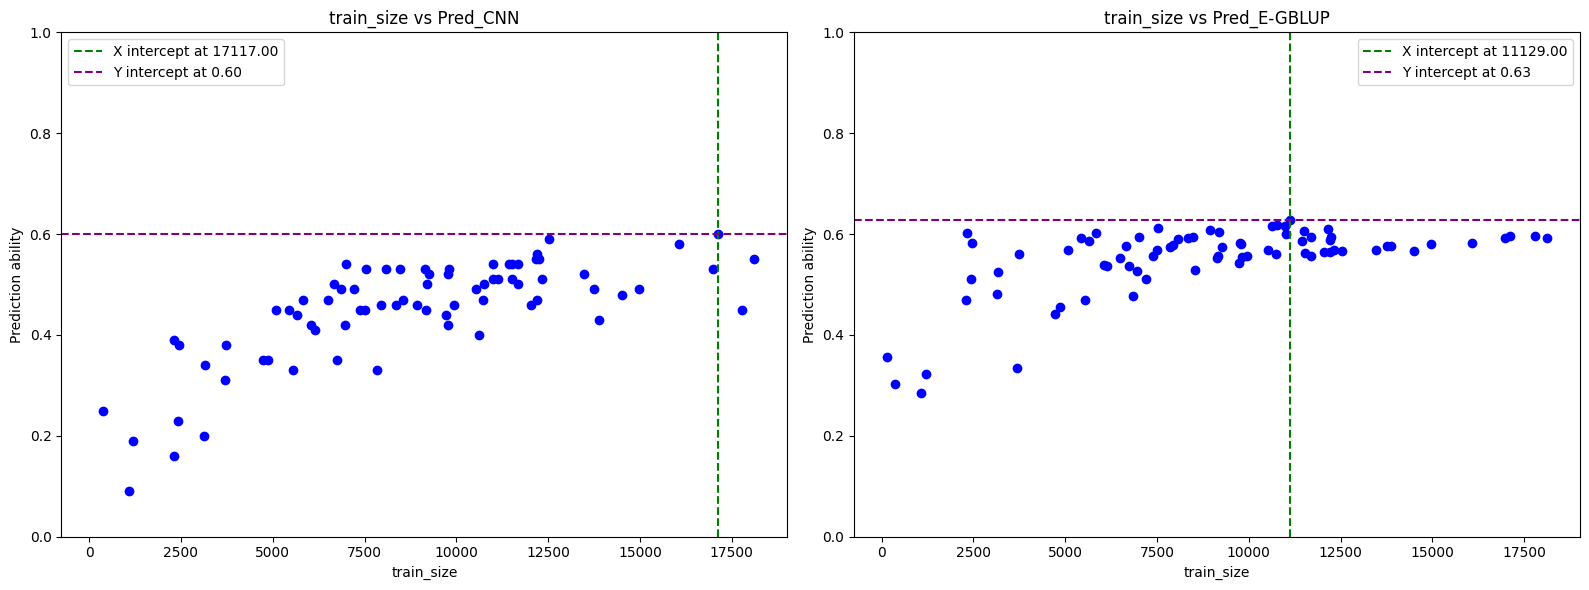

In [5]:
# Make plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Correlation
X_log = np.log(df_cleaned['train_size'].values.reshape(-1, 1))
y_corr = df_cleaned['Pred_CNN']

a_corr, b_corr = fit_regression_model(X_log, y_corr)
y_vals_log_corr = generate_smooth_line(a_corr, b_corr, X_log)
max_corr = np.max(y_corr)
max_corr_x = df_cleaned['train_size'][np.argmax(y_corr)]
plot_relationship(axes[0], df_cleaned['train_size'], y_corr, 
                  #y_vals_log_corr, 
                  max_corr, 
                  max_corr_x, 
                  'train_size vs Pred_CNN', 'Prediction ability')

# Plot for Prediction Ability
y_pred = df_cleaned['prediction_ablity']

a_pred, b_pred = fit_regression_model(X_log, y_pred)
y_vals_log_pred = generate_smooth_line(a_pred, b_pred, X_log)
max_pred_ability = np.max(y_pred)
max_pred_ability_x = df_cleaned['train_size'][np.argmax(y_pred)]
plot_relationship(axes[1], df_cleaned['train_size'], y_pred, 
                  #y_vals_log_pred, 
                  max_pred_ability, 
                  max_pred_ability_x, 
                  'train_size vs Pred_E-GBLUP', 'Prediction ability')

# Save the plot
plt.tight_layout()
plt.savefig('/proj/outputs/correlation_prediction_plot.png', format='png', dpi=100)
plt.show()

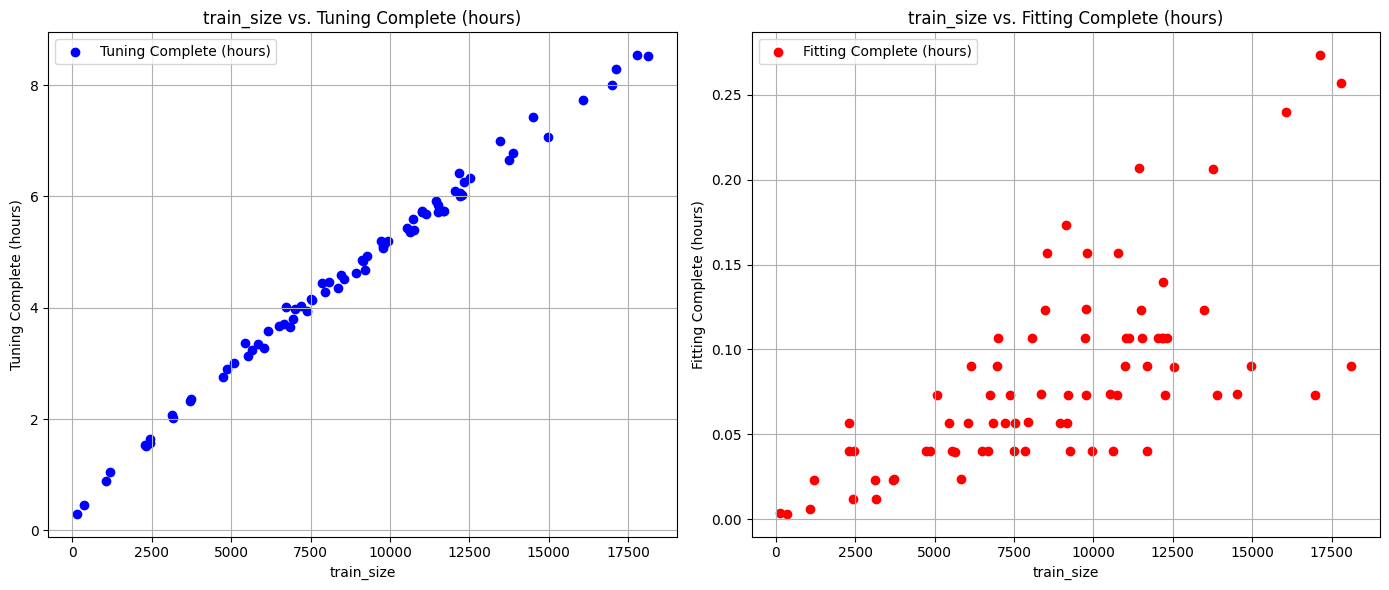

In [26]:
# Get run times
log_df = log_times_to_dataframe(logs)

df_cleaned_final = pd.merge(df_cleaned, log_df, left_on='Run', right_on='Run', how='left')

# Absent 
df_cleaned_final['Tuning Complete (hours)'].isna().sum()

# Plot
import matplotlib.pyplot as plt

# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plot 1: train_size vs. Tuning Complete (hours)
ax1.scatter(df_cleaned_final['train_size'], df_cleaned_final['Tuning Complete (hours)'], color='b', label='Tuning Complete (hours)')
ax1.set_xlabel('train_size')
ax1.set_ylabel('Tuning Complete (hours)')
ax1.set_title('train_size vs. Tuning Complete (hours)')
ax1.grid(True)
ax1.legend()

# Plot 2: train_size vs. Fitting Complete (hours)
ax2.scatter(df_cleaned_final['train_size'], df_cleaned_final['Fitting Complete (hours)'], color='r', label='Fitting Complete (hours)')
ax2.set_xlabel('train_size')
ax2.set_ylabel('Fitting Complete (hours)')
ax2.set_title('train_size vs. Fitting Complete (hours)')
ax2.grid(True)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('/proj/outputs/time_pred.png', format='png', dpi=100)
# Show the plots
plt.show()

In [27]:
# Simple time prediction
model = train_tuning_model(df_cleaned_final)

print(f"Predicted Tuning Time for train_size {2000}: {predict_tuning_time(model, 2000):.2f} hours")
print(f"Predicted Tuning Time for train_size {4000}: {predict_tuning_time(model, 4000):.2f} hours")
print(f"Predicted Tuning Time for train_size {8000}: {predict_tuning_time(model, 8000):.2f} hours")
print(f"Predicted Tuning Time for train_size {16000}: {predict_tuning_time(model, 16000):.2f} hours")

Predicted Tuning Time for train_size 2000: 1.54 hours
Predicted Tuning Time for train_size 4000: 2.44 hours
Predicted Tuning Time for train_size 8000: 4.25 hours
Predicted Tuning Time for train_size 16000: 7.86 hours


In [25]:
df_cleaned_final['n_series'] = [x.count(" + ") + 1 for x in df_cleaned_final['train_set'].to_list()]
# Print trends by n_series
r_cnn = df_cleaned_final.groupby('n_series').apply(
    lambda group: group['train_size'].corr(group['Pred_CNN'])
).round(2)

r_gblup = df_cleaned_final.groupby('n_series').apply(
    lambda group: group['train_size'].corr(group['prediction_ablity'])
).round(2)

print(f'correlation:\nCNN = {r_cnn}\nE-GBLUP = {r_gblup}')

correlation:
CNN = n_series
1    0.68
2    0.65
3    0.75
4    0.44
5    0.13
6    0.41
7    0.03
8     NaN
dtype: float64
E-GBLUP = n_series
1    0.46
2    0.50
3    0.66
4   -0.08
5   -0.09
6   -0.65
7    0.99
8     NaN
dtype: float64


/proj/py_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/proj/py_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/proj/py_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/proj/py_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
